In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import os
import time
import glob

In [4]:
def my_makedirs(path):
    if not os.path.isdir(path):
        os.makedirs(path)

In [5]:
def quenc_resistor(slope, unc):
    rq = 1./slope
    unc_rq = 1./(slope*slope)*unc
    return rq, unc_rq

In [16]:
def MeasurementsSiPMs(folder='84_Cold', measurement = 'vbd'):
    # Specify the folder path
    folder_path = './data/'+folder+'/*'
    # Get a list of all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

    # String to check for
    string_to_remove = "IV"

    # Remove elements containing the string
    filtered_list = [item for item in csv_files if string_to_remove not in item]

    if measurement == 'rq':
        rq_measuments = []
        df_append_rq = pd.DataFrame()

        filtered_list = [item for item in csv_files if measurement in item]
        
        print(filtered_list)
        for csv_file in filtered_list: 
            df = pd.read_csv(csv_file, skiprows=1,header=None)
            Voltage = np.array(df.iloc[:,1])
            Current = np.array(df.iloc[:,2])
            #print(Voltage)
            if folder == '84_before':
                # Select the range using boolean indexing
                Current = [Current[id] for id,x in enumerate(Voltage) if x > 0.75 and x < 1.25]
                Voltage = [x for x in Voltage if x > 0.75 and x < 1.25]
            else:
                Current = [Current[id] for id,x in enumerate(Voltage) if x > 1.5 and x <2.5]
                Voltage = [x for x in Voltage if x > 1.5 and x <2.5]
              
            # Perform linear regression
            result = linregress(Voltage, Current)
            rq_measuments.append(quenc_resistor(result.slope,result.stderr))

            slope = np.array(result.slope)
            #print(csv_file[:-4])

            plt.figure(dpi=150)
            plt.scatter(Voltage, Current, label='Measument')
            plt.plot(Voltage,slope * Voltage + result.intercept, color='red', label='Fit')
            plt.xlabel('Voltage (V)')
            plt.ylabel('Current (A)')
            plt.legend(title = rf'p0 = {round(result.intercept,4)}$\pm$ {round(result.intercept_stderr,6)}, p1 = {round(result.slope,5)}$\pm$ {round(result.stderr,7)}')
            plt.savefig(csv_file[:-4]+'_fit_rq.pdf', dpi = 150, format = 'pdf')
            plt.close()
        
        # Save the data columns in a CSV file
        rq_measuments = np.array(rq_measuments)
        data = pd.DataFrame({
        'Rq': rq_measuments[:,0],
        'Std_Rq': rq_measuments[:,1],
        #'Current Std (A)': currents_stds,
        })
        print(data)
        df_append_rq = pd.concat([df_append_rq,data], ignore_index=True)
        
        return filtered_list
    if measurement == 'vbd':
        filtered_list = [item for item in filtered_list if 'rq' not in item]
        return np.array([np.array(pd.read_csv(csv_file, header=None).iloc[:,1]) for csv_file in filtered_list]).reshape(-1)

In [17]:
arr = MeasurementsSiPMs(measurement='rq')

['./data/84_Cold/08161710C_cold/IV_Curve_both_08161710C_cold_rq_7.csv', './data/84_Cold/08161710C_cold/IV_Curve_both_08161710C_cold_rq_6.csv', './data/84_Cold/08161710C_cold/IV_Curve_both_08161710C_cold_rq_5.csv', './data/84_Cold/08161710C_cold/IV_Curve_both_08161710C_cold_rq_8.csv', './data/84_Cold/08161710C_cold/IV_Curve_both_08161710C_cold_rq_1.csv', './data/84_Cold/08161710C_cold/IV_Curve_both_08161710C_cold_rq_2.csv', './data/84_Cold/08161710C_cold/IV_Curve_both_08161710C_cold_rq_3.csv', './data/84_Cold/08161710C_cold/IV_Curve_both_08161710C_cold_rq_9.csv', './data/84_Cold/08161710C_cold/IV_Curve_both_08161710C_cold_rq_4.csv', './data/84_Cold/08191011D_cold/IV_Curve_both_08191011D_cold_rq_4.csv', './data/84_Cold/08191011D_cold/IV_Curve_both_08191011D_cold_rq_8.csv', './data/84_Cold/08191011D_cold/IV_Curve_both_08191011D_cold_rq_1.csv', './data/84_Cold/08191011D_cold/IV_Curve_both_08191011D_cold_rq_5.csv', './data/84_Cold/08191011D_cold/IV_Curve_both_08191011D_cold_rq_6.csv', './da

AttributeError: 'DataFrame' object has no attribute 'concat'

Slope: 1.0514285714285714
Intercept: -0.02857142857142847
R-squared: 0.9972312223858617
Std: 0.02770102775666402


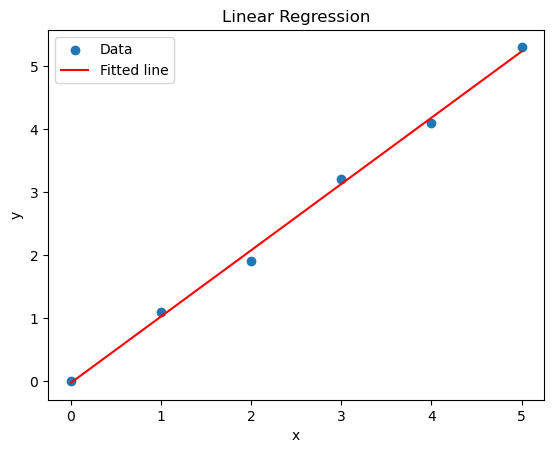

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Example data
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([0, 1.1, 1.9, 3.2, 4.1, 5.3])

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Print the results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"Std: {std_err}")

# Plot the data and the linear fit
plt.scatter(x, y, label='Data')
plt.plot(x, slope * x + intercept, color='red', label='Fitted line')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression')
plt.legend()
plt.show()
